# 데이터 다운로드

In [ ]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JxLLEBlwt8qtEOpxMSHAKRYapU7ycDaJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JxLLEBlwt8qtEOpxMSHAKRYapU7ycDaJ" -O open.zip && rm -rf ~/cookies.txt
!mkdir data
!unzip open.zip -d data
!rm open.zip

--2022-11-20 08:02:59--  https://docs.google.com/uc?export=download&confirm=t&id=1JxLLEBlwt8qtEOpxMSHAKRYapU7ycDaJ
Resolving docs.google.com (docs.google.com)... 142.251.12.113, 142.251.12.138, 142.251.12.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jmf3j5e5sa1omja69t4aq41k1jgvbll1/1668931350000/15503499385774260746/*/1JxLLEBlwt8qtEOpxMSHAKRYapU7ycDaJ?e=download&uuid=8bce762e-d1be-4a67-a2db-1841327bbf99 [following]
--2022-11-20 08:02:59--  https://doc-0s-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jmf3j5e5sa1omja69t4aq41k1jgvbll1/1668931350000/15503499385774260746/*/1JxLLEBlwt8qtEOpxMSHAKRYapU7ycDaJ?e=download&uuid=8bce762e-d1be-4a67-a2db-1841327bbf99
Resolving doc-0s-84-docs.googleusercontent.com (doc-0s-84-docs.googleusercontent.com)... 142.251.10.132, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
base = '/content/drive/MyDrive/colab_data/dacondata/'

In [ ]:
train_df = pd.read_csv(base + 'train_imgf_6ls.csv') # gleason score weights 5 / 6 logits mean(0 2 4 6 8 10)
test_df = pd.read_csv(base + 'test_imgf_6ls.csv') 

train_ratio = pd.read_csv(base + 'train_ratio2.csv') # ratio from whole image
test_ratio = pd.read_csv(base + 'test_ratio2.csv')
train_ratio3 = pd.read_csv(base + 'train_ratio3.csv') # ratio from whole image
test_ratio3 = pd.read_csv(base + 'test_ratio3.csv')


#train_df = pd.read_csv(base + 'train.csv')
#test_df = pd.read_csv(base + 'test.csv')

In [ ]:
# merge with ratio csv
train_ratio['path'] = train_ratio['path'].str.replace('.png', '')
train_ratio.columns = ['ID', 'ratio']
train_df = pd.merge(train_df, train_ratio)

test_ratio['path'] = test_ratio['path'].str.replace('.png', '')
test_ratio.columns = ['ID', 'ratio']
test_df = pd.merge(test_df, test_ratio)


train_ratio3['path'] = train_ratio3['path'].str.replace('.png', '')
train_ratio3.columns = ['ID', 'ratio2']
train_df = pd.merge(train_df, train_ratio3)

test_ratio3['path'] = test_ratio3['path'].str.replace('.png', '')
test_ratio3.columns = ['ID', 'ratio2']
test_df = pd.merge(test_df, test_ratio3)

# 전처리

In [ ]:
# 한글 컬럼명 영문으로 변경
train_df = train_df.rename(columns={'나이':'age','수술연월일':'date', '진단명':'Diagnosis', '암의 위치':'location', '암의 개수':'count', '암의 장경':'size', 'DCIS_or_LCIS_여부':'DCIS_or_LCIS_existence'}) 
test_df = test_df.rename(columns={'나이':'age','수술연월일':'date', '진단명':'Diagnosis', '암의 위치':'location', '암의 개수':'count', '암의 장경':'size', 'DCIS_or_LCIS_여부':'DCIS_or_LCIS_existence'}) 

## feature 변환

In [ ]:
# date 변환

import datetime as dt
someday = pd.to_datetime('2000-01-01')
train_df['date'] = pd.to_datetime(train_df['date']) - someday
train_df['date'] = train_df['date'].dt.days / 1000

test_df['date'] = pd.to_datetime(test_df['date']) - someday
test_df['date'] = test_df['date'].dt.days / 1000

In [ ]:
# 0이 의미가 있는 컬럼들은 숫자를 1씩 올려줘서 nan값이 채워질 0과 구분할수 있게 해준다.

train_df['DCIS_or_LCIS_existence'] += 1
train_df['ER'] += 1
train_df['HER2'] += 1
train_df['HER2_IHC'] += 1

test_df['DCIS_or_LCIS_existence'] += 1
test_df['ER'] += 1
test_df['HER2'] += 1
test_df['HER2_IHC'] += 1

In [ ]:
train_df['PR'] += 1
train_df['T_category'] += 1
train_df['BRCA_mutation'] += 1
train_df['HER2_SISH'] += 1

test_df['PR'] += 1
test_df['T_category'] += 1
test_df['BRCA_mutation'] += 1
test_df['HER2_SISH'] += 1

## 이상치 제거

In [ ]:
# 휴먼에러 제거
train_df['PR_Allred_score'].loc[train_df['PR_Allred_score']==23] = 3
train_df['PR_Allred_score'].loc[train_df['PR_Allred_score']==54] = 4

## One hot encoding

In [ ]:
# one hot encoding
train_df['location_left'] = train_df['location'].apply(lambda x :1 if x==1 else 0)
train_df['location_right'] = train_df['location'].apply(lambda x :1 if x==2 else 0)
train_df['location_both'] = train_df['location'].apply(lambda x :1 if x==3 else 0)

train_df['Diagnosis_ductal'] = train_df['Diagnosis'].apply(lambda x :1 if x==1 else 0)
train_df['Diagnosis_lobular'] = train_df['Diagnosis'].apply(lambda x :1 if x==2 else 0)
train_df['Diagnosis_mucinous'] = train_df['Diagnosis'].apply(lambda x :1 if x==3 else 0)
train_df['Diagnosis_other'] = train_df['Diagnosis'].apply(lambda x :1 if x==4 else 0)

test_df['location_left'] = test_df['location'].apply(lambda x :1 if x==1 else 0)
test_df['location_right'] = test_df['location'].apply(lambda x :1 if x==2 else 0)
test_df['location_both'] = test_df['location'].apply(lambda x :1 if x==3 else 0)

test_df['Diagnosis_ductal'] = test_df['Diagnosis'].apply(lambda x :1 if x==1 else 0)
test_df['Diagnosis_lobular'] = test_df['Diagnosis'].apply(lambda x :1 if x==2 else 0)
test_df['Diagnosis_mucinous'] = test_df['Diagnosis'].apply(lambda x :1 if x==3 else 0)
test_df['Diagnosis_other'] = test_df['Diagnosis'].apply(lambda x :1 if x==4 else 0)

train_df = train_df.drop(columns = ['location','Diagnosis',])
test_df = test_df.drop(columns = ['location','Diagnosis',])

## 결측치 채우기

In [ ]:

train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==1)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==1].median()
train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==2)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==2].median()
train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==3)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==3].median()
train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==4)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==4].median()


test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==1)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==1].median()
test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==2)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==2].median()
test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==3)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==3].median()
test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==4)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==4].median()


train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==1)] = train_df['size'].loc[train_df['T_category']==1].median()
train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==2)] = train_df['size'].loc[train_df['T_category']==2].median()
train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==3)] = train_df['size'].loc[train_df['T_category']==3].median()
train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==4)] = train_df['size'].loc[train_df['T_category']==4].median()


test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==1)] = train_df['size'].loc[train_df['T_category']==1].median()
test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==2)] = train_df['size'].loc[train_df['T_category']==2].median()
test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==3)] = train_df['size'].loc[train_df['T_category']==3].median()
test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==4)] = train_df['size'].loc[train_df['T_category']==4].median()


train_df['PR_Allred_score'].loc[(train_df['PR_Allred_score'].isnull() == True) & (train_df['NG']==1)] = train_df['PR_Allred_score'].loc[train_df['NG']==1].mean().astype(int)
train_df['PR_Allred_score'].loc[(train_df['PR_Allred_score'].isnull() == True) & (train_df['NG']==2)] = train_df['PR_Allred_score'].loc[train_df['NG']==2].mean().astype(int)
train_df['PR_Allred_score'].loc[(train_df['PR_Allred_score'].isnull() == True) & (train_df['NG']==3)] = train_df['PR_Allred_score'].loc[train_df['NG']==3].mean().astype(int)

test_df['PR_Allred_score'].loc[(test_df['PR_Allred_score'].isnull() == True) & (test_df['NG']==1)] = train_df['PR_Allred_score'].loc[train_df['NG']==1].mean().astype(int)
test_df['PR_Allred_score'].loc[(test_df['PR_Allred_score'].isnull() == True) & (test_df['NG']==2)] = train_df['PR_Allred_score'].loc[train_df['NG']==2].mean().astype(int)
test_df['PR_Allred_score'].loc[(test_df['PR_Allred_score'].isnull() == True) & (test_df['NG']==3)] = train_df['PR_Allred_score'].loc[train_df['NG']==3].mean().astype(int)



In [ ]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

## 컬럼삭제

In [ ]:
# 필수삭제 columns
train_df = train_df.drop(columns = ['ID','img_path','mask_path'])
test_df = test_df.drop(columns = ['ID','img_path'])

# 결과

## TEST

In [ ]:
%%shell
git clone https://github.com/h2oai/pystacknet
cd pystacknet
python setup.py install

Cloning into 'pystacknet'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (42/42), done.
running install
running bdist_egg
running egg_info
creating pystacknet.egg-info
writing pystacknet.egg-info/PKG-INFO
writing dependency_links to pystacknet.egg-info/dependency_links.txt
writing requirements to pystacknet.egg-info/requires.txt
writing top-level names to pystacknet.egg-info/top_level.txt
writing manifest file 'pystacknet.egg-info/SOURCES.txt'
adding license file 'LICENSE.txt'
writing manifest file 'pystacknet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/pystacknet
copying pystacknet/pystacknet.py -> build/lib/pystacknet
copying pystacknet/__init__.py -> build/lib/pystacknet
copying pystacknet/metrics.py -> build/lib/pystacknet
creating build/lib/pystacknet/test
copying pystacknet/tes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### XGBoost

In [ ]:
Y = train_df['N_category']
X = train_df.drop(columns = ['N_category'])


xtest = test_df.iloc[:,:]

from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.20,random_state=41) 


import xgboost as xgb

simple_model = xgb.XGBClassifier(
   n_estimators=500,
   max_depth=7,
   learning_rate=0.05,
   subsample=0.9,
#   colsample_bytree=0.9,
   
   random_state=2019,
   tree_method='gpu_hist',
 
)
simple_model.fit(xtrain, ytrain,eval_set=[(xtrain,ytrain),(xval,yval)], early_stopping_rounds=200,verbose=False, eval_metric = ["auc","error"])

pred = simple_model.predict(xval)

print(simple_model.score(xtrain,ytrain))
print(accuracy_score(pred, yval))
print(classification_report(yval, pred))

result = simple_model.predict(xtest)

0.9275
0.86
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       100
           1       0.90      0.81      0.85       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



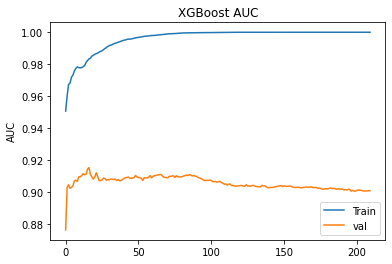

In [ ]:
results = simple_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='val')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

#### importance plot

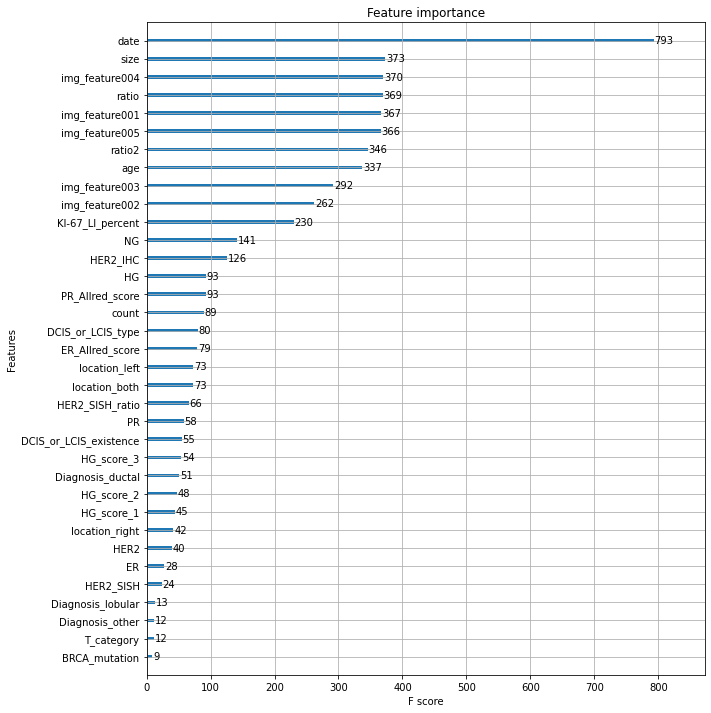

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(simple_model,ax=ax)

### XGB LGB models and training

In [ ]:
from sklearn.model_selection import TimeSeriesSplit,KFold
n_fold = 5
folds = KFold(n_splits=n_fold,shuffle=True)

Y = train_df['N_category']
X = train_df.drop(columns = ['N_category'])

xtest = test_df.iloc[:,:]

print(folds)

KFold(n_splits=5, random_state=None, shuffle=True)


In [ ]:
# LGB model kfold
sample_submission = pd.read_csv(base+'sample_submission.csv')
lgb_submission=sample_submission.copy()
lgb_submission['N_category'] = 0
import gc
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    print(fold_n)
    
    lgbclf = lgb.LGBMClassifier(
        num_leaves= 512,
        n_estimators=512,
        max_depth=9,
        learning_rate=0.064,
        subsample=0.85,
        colsample_bytree=0.85,
        boosting_type= "gbdt",
        reg_alpha=0.3,
        reg_lamdba=0.243
    )
    
    X_, X_valid = X.iloc[train_index], X.iloc[valid_index]
    Y_, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    lgbclf.fit(X_,Y_)
    
    del X_,Y_
    print('finish train')
    pred=lgbclf.predict_proba(xtest)[:,1]
    val=lgbclf.predict_proba(X_valid)[:,1]
    print('finish pred')
    del lgbclf, X_valid
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    lgb_submission['N_category'] = lgb_submission['N_category']+pred/n_fold
    del pred
    gc.collect()


0
finish train
finish pred
ROC accuracy: 0.9099749373433584
1
finish train
finish pred
ROC accuracy: 0.8507447665056361
2
finish train
finish pred
ROC accuracy: 0.8610444177671069
3
finish train
finish pred
ROC accuracy: 0.8954235246888799
4
finish train
finish pred
ROC accuracy: 0.9026548672566371


In [ ]:
# XGB model kfold
xgb_submission=sample_submission.copy()
xgb_submission['N_category'] = 0
import xgboost as xgb
from sklearn.metrics import roc_auc_score
for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    print(fold_n)
    xgbclf = xgb.XGBClassifier(
            n_estimators=500,
            max_depth=7,
            learning_rate=0.05,
            subsample=0.9,
            #   colsample_bytree=0.9,
            
            random_state=2019,
            tree_method='gpu_hist',
    )
    
    X_, X_valid = X.iloc[train_index], X.iloc[valid_index]
    Y_, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    xgbclf.fit(X_,Y_)
    del X_,Y_
    pred=xgbclf.predict_proba(xtest)[:,1]
    val=xgbclf.predict_proba(X_valid)[:,1]
    del xgbclf, X_valid
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    xgb_submission['N_category'] = xgb_submission['N_category']+pred/n_fold
    del pred
    gc.collect()



0
ROC accuracy: 0.8863181089743589
1
ROC accuracy: 0.9041466346153847
2
ROC accuracy: 0.8869318756959206
3
ROC accuracy: 0.8848631239935588
4
ROC accuracy: 0.8970662365157779


### Stacking models and training

In [ ]:
# Stacking model kfold
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
lgbclf = lgb.LGBMRegressor(
        num_leaves= 512,
        n_estimators=512,
        max_depth=9,
        learning_rate=0.064,
        subsample=0.85,
        colsample_bytree=0.85,
        boosting_type= "gbdt",
        reg_alpha=0.3,
        reg_lamdba=0.243,
        metric="AUC"
    )
xgbclf = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.9,
        #   colsample_bytree=0.9,
        
        random_state=2019,
        tree_method='gpu_hist',
    )
rfclf = RandomForestRegressor(n_estimators=512,
                              max_depth=5, 
                                max_features='sqrt', 
                                random_state=0)

In [ ]:
models = [[lgbclf,xgbclf], # Level 1
          [rfclf]] # Level 2

cut down features to avoid the kernel die

In [ ]:
X=X.replace(np.inf,-999)
X=X.replace(-np.inf,-999)
xtest=xtest.replace(np.inf,-999)
xtest=xtest.replace(-np.inf,-999)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X, Y)
feature_cols=X.columns.values.tolist()


feature_imp=sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feature_cols), 
             reverse=True)
print(feature_imp)
del rf

[(0.3352, 'date'), (0.1234, 'NG'), (0.0673, 'HG_score_2'), (0.0604, 'size'), (0.0348, 'img_feature004'), (0.0323, 'ratio'), (0.0319, 'img_feature001'), (0.0317, 'img_feature005'), (0.0316, 'ratio2'), (0.0315, 'age'), (0.0232, 'img_feature003'), (0.0218, 'PR_Allred_score'), (0.021, 'DCIS_or_LCIS_existence'), (0.0192, 'img_feature002'), (0.019, 'DCIS_or_LCIS_type'), (0.0189, 'KI-67_LI_percent'), (0.0126, 'location_both'), (0.0088, 'HER2_SISH_ratio'), (0.0085, 'Diagnosis_lobular'), (0.008, 'HER2_IHC'), (0.0072, 'count'), (0.0066, 'HG_score_1'), (0.0064, 'HG'), (0.0061, 'ER_Allred_score'), (0.0047, 'HG_score_3'), (0.0044, 'T_category'), (0.0038, 'location_left'), (0.0033, 'PR'), (0.003, 'location_right'), (0.003, 'HER2'), (0.0028, 'HER2_SISH'), (0.0026, 'ER'), (0.0019, 'Diagnosis_ductal'), (0.0014, 'Diagnosis_other'), (0.001, 'BRCA_mutation'), (0.0004, 'Diagnosis_mucinous')]


In [ ]:
len(feature_imp)

36

In [ ]:
feature_imp=[x[1] for x in feature_imp]
X=X[feature_imp[:27]].values
xtest=xtest[feature_imp[:27]].values

print('reduce dimention finished')

reduce dimention finished


In [ ]:
from pystacknet.pystacknet.pystacknet import StackNetClassifier

# Specify parameters for stacked model and begin training
model = StackNetClassifier(models, 
                           metric="auc", 
                           folds=5,
                           restacking=False,
                           use_retraining=True,
                           use_proba=True, # To use predict_proba after training
                           random_state=0,
                           n_jobs=1, 
                           verbose=1)

# Fit the entire model tree
del models
model.fit(X, Y)

====================== Start of Level 0 ======================
Input Dimensionality 27 at Level 0 
2 models included in Level 0 
[02:23:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 1/5 , model 0 , auc===0.863960 
Fold 1/5 , model 1 , auc===0.882105 
=========== end of fold 1 in level 0 ===========
[02:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 2/5 , model 0 , auc===0.873545 
Fold 2/5 , model 1 , auc===0.892212 
=========== end of fold 2 in level 0 ===========
[02:24:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 3/5 , model 0 , auc===0.875924 
Fold 3/5 , model 1 , auc===0.885057 
=========== end of fold 3 in level 0 ===========
[02:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarede

### Predict and Export

In [ ]:
# Write predictions to csv
stack_submission = sample_submission.copy()
preds = model.predict_proba(xtest)[:, 1]
stack_submission['N_category'] = preds

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 


In [ ]:
stack_submission

,ID,N_category
0,BC_01_0011,0.527366
1,BC_01_0220,0.230202
2,BC_01_0233,0.054945
3,BC_01_0258,0.071921
4,BC_01_0260,0.657415
...,...,...
245,BC_01_3328,0.861613
246,BC_01_3404,0.261123
247,BC_01_3418,0.326953
248,BC_01_3438,0.034212


In [ ]:
# voting
ensemble=sample_submission.copy()
ensemble.N_category=lgb_submission.N_category*0.4+xgb_submission.N_category*0.4+stack_submission.N_category*0.2
# ensemble.N_category=lgb_submission.N_category*0.5+xgb_submission.N_category*0.5
ensemble.N_category = np.where(ensemble.N_category >= 0.5 , 1, 0)
ensemble.to_csv('xgb_lgb_stacking305.csv', index=False)


In [ ]:
print(ensemble.head())

           ID  N_category
0  BC_01_0011           1
1  BC_01_0220           0
2  BC_01_0233           0
3  BC_01_0258           0
4  BC_01_0260           1


In [ ]:
ensemble['N_category'].value_counts()

0    129
1    121
Name: N_category, dtype: int64